In [1]:
# !pip install matplotlib
# !pip install gurobipy
# !pip install torch_geometric

In [2]:
# !pip install scikit-learn

In [3]:
import gurobipy as gp
from gurobipy import GRB
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader  # Corrected import
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool  # For pooling in the decoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import matplotlib.pyplot as plt  # For plotting losses

In [4]:
from parse_QP import my_callback

In [5]:
# Read the problem
number = "0031"
grb_model = gp.read(f"QPLIB_{number}.lp")

# Solution storage
grb_model._feasible_solutions = []
grb_model._relaxation_solutions = []
grb_model.setParam("MIPGap", 0.05)
#model.setParam("NodeLimit", 100)  # Explore a limited number of nodes

# Optimize
grb_model.optimize(my_callback)

Restricted license - for non-production use only - expires 2026-11-23
Read LP format model from file QPLIB_0031.lp
Reading time = 0.00 seconds
obj: 32 rows, 60 columns, 120 nonzeros
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel Xeon Processor (Icelake), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.05

Optimize a model with 32 rows, 60 columns and 120 nonzeros
Model fingerprint: 0x00d24133
Model has 464 quadratic objective terms
Variable types: 30 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e+01, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 3654.4800000
Presolve time: 0.00s
Presolved: 901 rows, 526 columns, 2321 nonzeros
Preso

In [6]:
# Retrieve optimal solution if available
if grb_model.status == GRB.OPTIMAL:
    optimal_solution = grb_model.getAttr('X', grb_model.getVars())
    print("Optimal solution:", optimal_solution)
else:
    print(f"Model status: {grb_model.status}")

Optimal solution: [0.0, 0.0, 0.3328307282391785, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1574644983911741, 0.25564451699144053, 0.0, 0.16105507040036132, 0.0, 0.0, 0.09300518597785103, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 1.0, 0.0, -0.0, -0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, -0.0, 0.0, 1.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]


In [7]:
## Extracting bounds

import gurobipy as gp

# Read the problem
number = "0031"
grb_model = gp.read(f"QPLIB_{number}.lp")

variable_bounds = {}
for var in grb_model.getVars():
    variable_bounds[var.VarName] = {'Lower': var.LB, 'Upper': var.UB}


Read LP format model from file QPLIB_0031.lp
Reading time = 0.00 seconds
obj: 32 rows, 60 columns, 120 nonzeros


In [31]:
## Extracting Q, A, b, d, etc

from parse_QP import parse_qplib_file

# Replace '0031' with the desired file number
data = parse_qplib_file('0031')

# Access the data
A = data['A']
b_vector = data['b_vector']
E = data['E']
d = data['d']
Q = data['Q']
variables_info = data['variables_info']
variables_info = [v[0] for v in variables_info]
binary_indices = data['binary_indices']
variable_indices = data['variable_indices']

m, n = A.shape
# Get indices of non-zero elements in A
row_indices, col_indices = np.nonzero(A)
edge_weights = A[row_indices, col_indices]

# Map variable types to numerical values
# Node types: 0 - continuous, 1 - binary
variable_types = np.array([0 if v[0] == 'x' else 1 for v in variables_info])

# Collect indices of continuous and binary variables
continuous_indices = np.where(variable_types == 0)[0]
binary_indices = np.where(variable_types == 1)[0]
n_continuous = len(continuous_indices)
n_binary = len(binary_indices)


In [9]:
### Generating data and just reloading it if it's already generated (to save time)

import os
import pickle
from generate_solutions import generate_feasible_solutions, generate_infeasible_solutions

# Set generate_new to False by default
generate_new = True
feasible_data_file = 'feasible_data.pkl'
infeasible_data_file = 'infeasible_data.pkl'

if not generate_new and os.path.exists(feasible_data_file) and os.path.exists(infeasible_data_file):
    # Load feasible data
    with open(feasible_data_file, 'rb') as f:
        feasible_data = pickle.load(f)
    feasible_solutions = feasible_data['solutions']
    feasible_costs = feasible_data['costs']

    # Load infeasible data
    with open(infeasible_data_file, 'rb') as f:
        infeasible_data = pickle.load(f)
    infeasible_solutions = infeasible_data['solutions']
    infeasible_costs = infeasible_data['costs']

    print("Loaded existing feasible and infeasible solutions from files.")
else:
    # Generate feasible solutions
    num_objectives = 500  # Adjust the number as needed
    feasible_solutions, feasible_costs = generate_feasible_solutions(A, E, Q, variables_info, b_vector, d, num_objectives)

Generating Feasible Solutions: 100%|██████████| 500/500 [00:57<00:00,  8.66it/s]


In [10]:
# feasible_solutions[0].T @ Q @feasible_solutions[0]

In [23]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming feasible_solutions, cost_values, and Q are already defined
# Prepare edge information from Q
d = Q.shape[0]

# Create a complete graph by connecting every node to every other node
edge_indices = np.array(np.meshgrid(np.arange(d), np.arange(d))).reshape(2, -1)
edge_index = torch.tensor(edge_indices, dtype=torch.long)
edge_attr = torch.tensor(Q.flatten(), dtype=torch.float)

# Create Data objects
data_list = []
for i, x in enumerate(feasible_solutions):
    node_features = torch.tensor(x, dtype=torch.float).unsqueeze(1)
    y = torch.tensor([feasible_costs[i]], dtype=torch.float)

    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data_list.append(data)

# Normalize node features
all_node_features = torch.cat([data.x for data in data_list], dim=0)
mean = all_node_features.mean()
std = all_node_features.std()
for data in data_list:
    data.x = (data.x - mean) / std

# Normalize target costs
all_targets = torch.tensor([data.y.item() for data in data_list])
target_mean = all_targets.mean()
target_std = all_targets.std()
for data in data_list:
    data.y = (data.y - target_mean) / target_std

# Split into train and test sets
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Define the model
class GNNModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

# Initialize model, optimizer, and loss function
model = GNNModel(hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Training loop
def train():
    model.train()
    total_loss = 0
    total_original_loss = 0  # To accumulate loss in original cost values
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out.view(-1), data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs

        # Compute loss in original cost values
        # De-normalize predictions and targets
        pred_cost = out.view(-1) * target_std + target_mean
        actual_cost = data.y.view(-1) * target_std + target_mean
        original_loss = criterion(pred_cost, actual_cost)
        total_original_loss += original_loss.item() * data.num_graphs

    average_loss = total_loss / len(train_data)
    average_original_loss = total_original_loss / len(train_data)
    return average_loss, average_original_loss

# Testing
def test(loader):
    model.eval()
    total_loss = 0
    total_original_loss = 0
    with torch.no_grad():
        for data in loader:
            out = model(data)
            loss = criterion(out.view(-1), data.y.view(-1))
            total_loss += loss.item() * data.num_graphs

            # Compute loss in original cost values
            pred_cost = out.view(-1) * target_std + target_mean
            actual_cost = data.y.view(-1) * target_std + target_mean
            original_loss = criterion(pred_cost, actual_cost)
            total_original_loss += original_loss.item() * data.num_graphs

    average_loss = total_loss / len(loader.dataset)
    average_original_loss = total_original_loss / len(loader.dataset)
    return average_loss, average_original_loss

# Training epochs
for epoch in range(1, 31):
    loss, original_loss = train()
    if epoch % 1 == 0:
        print(f'Epoch {epoch}, Normalized Loss: {loss:.4f}, Original Loss: {original_loss:.4f}')

# Testing
test_loss, test_original_loss = test(test_loader)
print(f'\nTest Normalized MSE Loss: {test_loss:.4f}, Test Original MSE Loss: {test_original_loss:.4f}')

# Function to display predictions
def show_predictions(data_list, loader_name="Training"):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for data in data_list:
            data = data.to('cpu')
            out = model(data)
            # De-normalize predictions and targets
            pred_cost = out.item() * target_std.item() + target_mean.item()
            actual_cost = data.y.item() * target_std.item() + target_mean.item()
            predictions.append(pred_cost)
            actuals.append(actual_cost)
    print(f"\n{loader_name} Set Predictions:")
    for i in range(len(predictions)):
        print(f"Sample {i+1}: Predicted Cost = {predictions[i]:.4f}, Actual Cost = {actuals[i]:.4f}")

# Show predictions for the training set
show_predictions(train_data, loader_name="Training")

# Show predictions for the test set
show_predictions(test_data, loader_name="Test")


Epoch 1, Normalized Loss: 0.9811, Original Loss: 0.1337
Epoch 2, Normalized Loss: 0.9362, Original Loss: 0.1276
Epoch 3, Normalized Loss: 0.9055, Original Loss: 0.1234
Epoch 4, Normalized Loss: 0.7908, Original Loss: 0.1078
Epoch 5, Normalized Loss: 0.6086, Original Loss: 0.0830
Epoch 6, Normalized Loss: 0.4904, Original Loss: 0.0669
Epoch 7, Normalized Loss: 0.4112, Original Loss: 0.0560
Epoch 8, Normalized Loss: 0.3173, Original Loss: 0.0432
Epoch 9, Normalized Loss: 0.2342, Original Loss: 0.0319
Epoch 10, Normalized Loss: 0.2145, Original Loss: 0.0292
Epoch 11, Normalized Loss: 0.1601, Original Loss: 0.0218
Epoch 12, Normalized Loss: 0.1757, Original Loss: 0.0240
Epoch 13, Normalized Loss: 0.1247, Original Loss: 0.0170
Epoch 14, Normalized Loss: 0.1485, Original Loss: 0.0202
Epoch 15, Normalized Loss: 0.0922, Original Loss: 0.0126
Epoch 16, Normalized Loss: 0.0716, Original Loss: 0.0098
Epoch 17, Normalized Loss: 0.0534, Original Loss: 0.0073
Epoch 18, Normalized Loss: 0.0416, Origi

In [24]:
show_predictions(test_data, loader_name="Test")


Test Set Predictions:
Sample 1: Predicted Cost = 0.7341, Actual Cost = 0.7254
Sample 2: Predicted Cost = 0.9445, Actual Cost = 0.9573
Sample 3: Predicted Cost = 0.0120, Actual Cost = 0.0051
Sample 4: Predicted Cost = 0.4649, Actual Cost = 0.4700
Sample 5: Predicted Cost = 0.5705, Actual Cost = 0.5749
Sample 6: Predicted Cost = 0.0120, Actual Cost = 0.0043
Sample 7: Predicted Cost = 0.0120, Actual Cost = 0.0055
Sample 8: Predicted Cost = 0.9132, Actual Cost = 0.9405
Sample 9: Predicted Cost = 0.6343, Actual Cost = 0.6337
Sample 10: Predicted Cost = 0.0118, Actual Cost = 0.0060
Sample 11: Predicted Cost = 0.0119, Actual Cost = 0.0059
Sample 12: Predicted Cost = 0.7080, Actual Cost = 0.6972
Sample 13: Predicted Cost = 0.0120, Actual Cost = 0.0046
Sample 14: Predicted Cost = 0.0119, Actual Cost = 0.0063
Sample 15: Predicted Cost = 0.8637, Actual Cost = 0.8952
Sample 16: Predicted Cost = 0.5064, Actual Cost = 0.4535
Sample 17: Predicted Cost = 0.8201, Actual Cost = 0.8029
Sample 18: Predic

In [25]:
def predict_single_solution(model, x_vector, edge_index, edge_attr, mean, std, target_mean, target_std):

    model.eval()  # Set the model to evaluation mode

    # Ensure x_vector is a torch tensor
    if isinstance(x_vector, np.ndarray):
        x_vector = torch.tensor(x_vector, dtype=torch.float)

    # Normalize the node features
    x_normalized = (x_vector - mean) / std
    x_normalized = x_normalized.unsqueeze(1)  # Add feature dimension

    # Create a Data object
    data = Data(x=x_normalized, edge_index=edge_index, edge_attr=edge_attr)

    # Since we're predicting for a single graph, we need to add a batch attribute
    data.batch = torch.zeros(x_normalized.size(0), dtype=torch.long)

    with torch.no_grad():
        out = model(data)
        # De-normalize the prediction to get the cost in the original scale
        pred_cost = out.item() * target_std.item() + target_mean.item()

    return pred_cost


Generating Feasible Solutions: 100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


Sample 1: Predicted Cost = 0.9427, Actual Cost = 0.9322
Sample 2: Predicted Cost = 0.8430, Actual Cost = 0.8439
Sample 3: Predicted Cost = 0.0119, Actual Cost = 0.0056
Sample 4: Predicted Cost = 0.9539, Actual Cost = 0.8874
Sample 5: Predicted Cost = 0.9478, Actual Cost = 0.9489
Sample 6: Predicted Cost = 0.0119, Actual Cost = 0.0059
Sample 7: Predicted Cost = 0.0120, Actual Cost = 0.0051
Sample 8: Predicted Cost = 0.0119, Actual Cost = 0.0068
Sample 9: Predicted Cost = 0.0119, Actual Cost = 0.0064
Sample 10: Predicted Cost = 0.9226, Actual Cost = 0.9493
Sample 11: Predicted Cost = 0.9514, Actual Cost = 0.9212
Sample 12: Predicted Cost = 0.9446, Actual Cost = 0.9345
Sample 13: Predicted Cost = 0.7155, Actual Cost = 0.6894
Sample 14: Predicted Cost = 0.8911, Actual Cost = 0.8668
Sample 15: Predicted Cost = 0.0120, Actual Cost = 0.0048
Sample 16: Predicted Cost = 0.9345, Actual Cost = 0.9525
Sample 17: Predicted Cost = 0.9543, Actual Cost = 0.9478
Sample 18: Predicted Cost = 0.9452, Actu

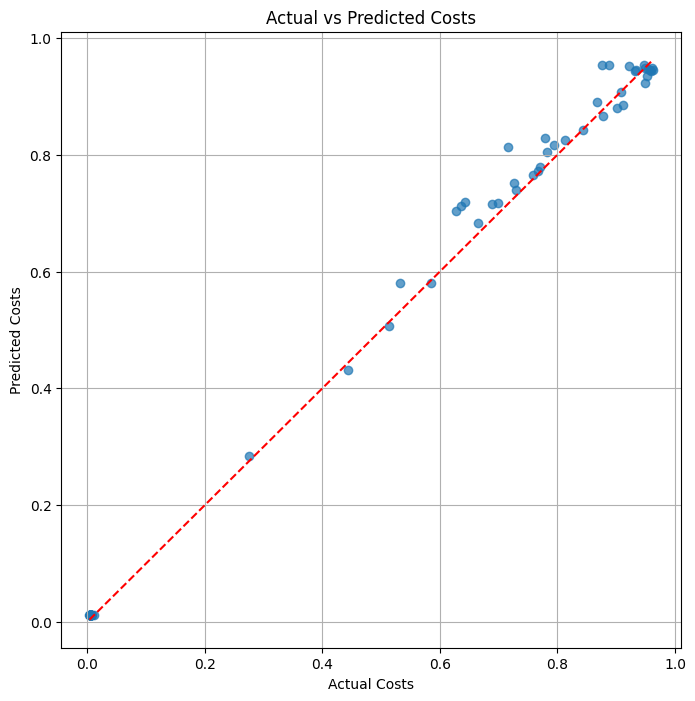

In [34]:
import os
import pickle
import torch
import matplotlib.pyplot as plt
from generate_solutions import generate_feasible_solutions
from torch_geometric.data import Data

# Assuming A, E, Q, variables_info, b_vector, d are already defined
# Also assuming that model, mean, std, target_mean, target_std, edge_index, edge_attr are defined from your training code

# Generate feasible solutions
num_objectives = 100  # Number of samples to generate
new_feasible_solutions, new_feasible_costs = generate_feasible_solutions(
    A, E, Q, variables_info, b_vector, d, num_objectives
)

# Function to predict cost for a single solution
def predict_single_solution(model, x_vector, edge_index, edge_attr, mean, std, target_mean, target_std):
    model.eval()
    with torch.no_grad():
        node_features = torch.tensor(x_vector, dtype=torch.float).unsqueeze(1)
        # Normalize node features
        node_features = (node_features - mean) / std
        # Create Data object
        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
        # Get prediction
        out = model(data)
        # De-normalize prediction
        predicted_cost = out.item() * target_std.item() + target_mean.item()
    return predicted_cost

# Collect actual and predicted costs
actual_costs = []
predicted_costs = []

# Predict costs and collect data
for i in range(len(new_feasible_solutions)):
    x_vector = new_feasible_solutions[i]
    actual_cost = new_feasible_costs[i]
    predicted_cost = predict_single_solution(
        model=model,
        x_vector=x_vector,
        edge_index=edge_index,
        edge_attr=edge_attr,
        mean=mean,
        std=std,
        target_mean=target_mean,
        target_std=target_std
    )
    actual_costs.append(actual_cost)
    predicted_costs.append(predicted_cost)
    # Optionally, print some sample predictions
    if i < 50:
        print(f"Sample {i+1}: Predicted Cost = {predicted_cost:.4f}, Actual Cost = {actual_cost:.4f}")

# Plot actual vs predicted costs
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(actual_costs, predicted_costs, alpha=0.7)
plt.plot([min(actual_costs), max(actual_costs)], [min(actual_costs), max(actual_costs)], 'r--')  # Perfect prediction line
plt.xlabel("Actual Costs")
plt.ylabel("Predicted Costs")
plt.title("Actual vs Predicted Costs")
plt.grid(True)
plt.show()
